# Automated Sensing of Red vs. White Wine
_... with the cheapest sensor possible_

#### Data Science 420 BB
#### University of Washington Professional & Continuing Education

#### Homework 2: Low-cost Sensor, Desigion Trees
#### Leo Salemann, 4/25/18

# OBJECTIVES

1. Design a simple, low-cost sensor that can distinguish between red wine and white wine for at least 95%
of the samples. In other words, achive 95% accuracy with the minimum number of features.
1. Assess Accuracy when using all sensors
1. Find the ninimum number of sensors that still maintains 90% accuracy or better.

# LOAD DATA

In [1]:
file <- "./RedWhiteWine.csv"
data <- read.csv(file, header=TRUE, sep=",", stringsAsFactors = FALSE)

# If the target column, say column class, is numerical, you need to convert it to factors in R for classification problem
data$Class <- factor(data$Class)
head(data)
dim(data)


fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality,Class
7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5,1
7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,5,1
7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,5,1
11.2,0.28,0.56,1.9,0.075,17,60,0.9980,3.16,0.58,9.8,6,1
7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5,1
7.4,0.66,0.00,1.8,0.075,13,40,0.9978,3.51,0.56,9.4,5,1


[1] 6497   13

# ==============< JUNK  V2 >===================================

In [7]:
# install.packages("dplyr")
library(dplyr)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



## Redefine Class 1 as Red and 0 as White

In [ ]:
select(data, -Class)
head(data)

# Make a function that quickly tests Decision Tree accuracy

In [2]:
# Classification Tree with rpart
library(rpart)

Very similar to homework 1 (go figure), but it uses rpart/tree model instead of nbc

In [3]:
options(repr.plot.width=12, repr.plot.height=12)

test_tree_accuracy <- function(df, plot=FALSE) {
 
    # df = select(df, -Color)
    # split into test and training sets
    nrows <- nrow(df)
    smp_size <- floor(0.75 * nrows)

    set.seed(42)
    train_ind <- sample(seq_len(nrows), size = smp_size)
    
    train <- df[train_ind, ]
    test <- df[-train_ind, ]
    
    formula <- as.formula('Class ~ .')

    # grow tree 
    tree_model <- rpart(formula,
                 method="class", data=train, control=rpart.control(minsplit=30, cp=0.01))
    
    if (plot) {
        # plot tree 
        plot(tree_model, uniform=TRUE, 
             main="Classification Tree for Adult Income")
        text(tree_model, use.n=TRUE, all=TRUE, cex=.8)
    }
    
    # Make a prediction & test accuracy
    test_pred <- predict(tree_model, test, type = "class")
    
    ### junky debug stuff
    # print(head (test_pred))
    ### junky debug stuff
    accuracy <- sum(test[,"Class"]==test_pred)/length(test_pred)
    print("-------------------------------------------------------------------")
    print(colnames(df))
    print(paste("Accuracy=", round(accuracy*100,2), "%", sep=""))
    print("------------------------------------")
    print(paste(''))
    # try to do the AUC
    # print(paste("AUC=", auc(test_pred, df$Class)))

}

# Accuracy With All Attributes

In [4]:
test_tree_accuracy(data)

[1] "-------------------------------------------------------------------"
 [1] "fixed.acidity"        "volatile.acidity"     "citric.acid"         
 [4] "residual.sugar"       "chlorides"            "free.sulfur.dioxide" 
 [7] "total.sulfur.dioxide" "density"              "pH"                  
[10] "sulphates"            "alcohol"              "quality"             
[13] "Class"               
[1] "Accuracy=97.72%"
[1] "------------------------------------"
[1] ""


Okay, 97.72% accuracy (NBC was 97.91%). Not bad.  Let's start keeping score.

| Configuration | Tree Accuracy | NBC Acuracy |
|---------------|---------------|-------------|
|All features   | 97.72%        |  97.91%     |

# Accuracy With Minimal Subset and 95% Threshold

## Simplest Case First: Single-Feature Sensor
Presumably, the cheapest sensor we can design and build is one that samples only a single paremeter. Given our small search space (6 features) and reusable function, we can do a quick check in six lines of code

In [5]:
colnames(data)

[1] "fixed.acidity"        "volatile.acidity"     "citric.acid"         
 [4] "residual.sugar"       "chlorides"            "free.sulfur.dioxide" 
 [7] "total.sulfur.dioxide" "density"              "pH"                  
[10] "sulphates"            "alcohol"              "quality"             
[13] "Class"

In [8]:
test_tree_accuracy(select(data, fixed.acidity, Class))
test_tree_accuracy(select(data, volatile.acidity, Class))
test_tree_accuracy(select(data, citric.acid, Class))
test_tree_accuracy(select(data, residual.sugar, Class))
test_tree_accuracy(select(data, chlorides, Class))
test_tree_accuracy(select(data, free.sulfur.dioxide, Class))
test_tree_accuracy(select(data, total.sulfur.dioxide, Class))
test_tree_accuracy(select(data, density, Class))
test_tree_accuracy(select(data, pH, Class))
test_tree_accuracy(select(data, sulphates, Class))
test_tree_accuracy(select(data, alcohol, Class))

[1] "-------------------------------------------------------------------"
[1] "fixed.acidity" "Class"        
[1] "Accuracy=80.92%"
[1] "------------------------------------"
[1] ""
[1] "-------------------------------------------------------------------"
[1] "volatile.acidity" "Class"           
[1] "Accuracy=86.22%"
[1] "------------------------------------"
[1] ""
[1] "-------------------------------------------------------------------"
[1] "citric.acid" "Class"      
[1] "Accuracy=80.25%"
[1] "------------------------------------"
[1] ""
[1] "-------------------------------------------------------------------"
[1] "residual.sugar" "Class"         
[1] "Accuracy=83.57%"
[1] "------------------------------------"
[1] ""
[1] "-------------------------------------------------------------------"
[1] "chlorides" "Class"    
[1] "Accuracy=91.94%"
[1] "------------------------------------"
[1] ""
[1] "-------------------------------------------------------------------"
[1] "free.sulfur.dio

Okay, if our threshold is 90%, we can go down to a single feature (Sulfur Dioxide) If we want 95% or better, we need to keep looking. Time to update the leaderboard:

| Configuration                 | Tree Accuracy | NBC Acuracy |
|-------------------------------|---------------|-------------|
|All features                   | 97.72%        | 97.91%      |
|1 feature (sulfur.dioxide)     | 93.05%        | 93.11%      |
|1 feature (chloride)           | 91.94%        | 79.57%      |

So, for the cheapest possible sensorwith at least 90% accuracy, you can detect either sulfur.dioxide or chloride (which ever chemical is chheaper to detect).

Switching from _Business Mode_ to _Academic Mode_, we'll expend some extra resources to see what else we can do with this data and these decision trees.


To keep it intresting, we'll see if we can make a sensor with 90% or better accuracy, using as few sensors as possible, but still at lest two.

After googling _R rpart tree pruning_

In [40]:
fit <- rpart (Class ~ ., method="class", data=data)
printcp (fit)


Classification tree:
rpart(formula = Class ~ ., data = data, method = "class")

Variables actually used in tree construction:
[1] chlorides            total.sulfur.dioxide volatile.acidity    

Root node error: 1599/6497 = 0.24611

n= 6497 

        CP nsplit rel error   xerror      xstd
1 0.700438      0  1.000000 1.000000 0.0217134
2 0.067542      1  0.299562 0.332083 0.0138097
3 0.062539      2  0.232020 0.255159 0.0122292
4 0.017511      4  0.106942 0.116948 0.0084281
5 0.016260      5  0.089431 0.101939 0.0078837
6 0.010000      6  0.073171 0.090056 0.0074211


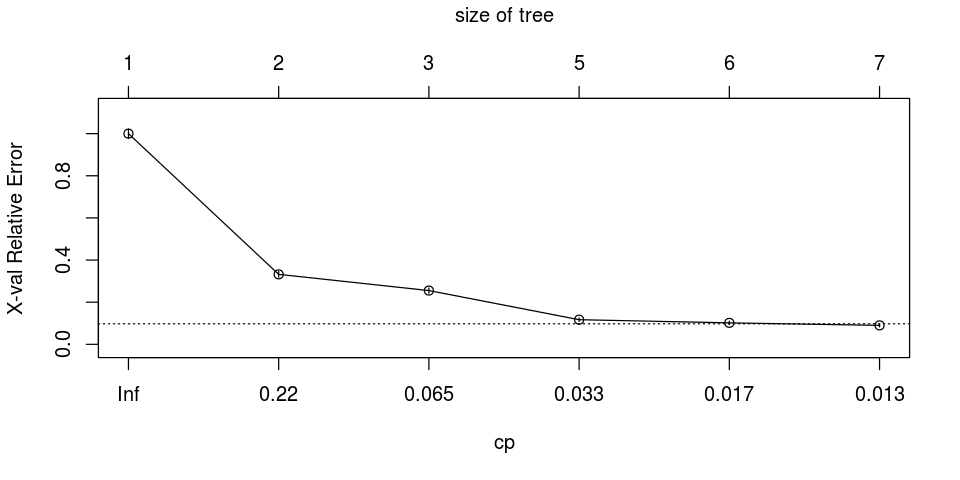

In [42]:
options(repr.plot.width=8, repr.plot.height=4)
plotcp(fit)

In [43]:
summary(fit)

Call:
rpart(formula = Class ~ ., data = data, method = "class")
  n= 6497 

          CP nsplit  rel error     xerror        xstd
1 0.70043777      0 1.00000000 1.00000000 0.021713445
2 0.06754221      1 0.29956223 0.33208255 0.013809692
3 0.06253909      2 0.23202001 0.25515947 0.012229203
4 0.01751094      4 0.10694184 0.11694809 0.008428118
5 0.01626016      5 0.08943089 0.10193871 0.007883661
6 0.01000000      6 0.07317073 0.09005629 0.007421057

Variable importance
total.sulfur.dioxide            chlorides  free.sulfur.dioxide 
                  34                   21                   13 
    volatile.acidity        fixed.acidity          citric.acid 
                  11                    7                    6 
             density            sulphates       residual.sugar 
                   3                    2                    2 
                  pH 
                   1 

Node number 1: 6497 observations,    complexity param=0.7004378
  predicted class=0  expected lo

Okay, the sumary says Total Sulfur Dioxide is the most important, follwed by Chloriede. The plot(cp) sugests we can get decent peformance improvment for up to 4 variables, but after that the law of diminishing returns kicks in.

Let's try a tree with total.sulfur.dioxide, chlorides, free.sulfur.dioxide, volatile.acidity. We'll start with just the first two attributes (we already tested free.sulfur.dioxid alone), then three, then four.

In [45]:
test_tree_accuracy(select(data, one_of(c('Class','total.sulfur.dioxide'))))
test_tree_accuracy(select(data, one_of(c('Class','total.sulfur.dioxide', 'chlorides'))))
test_tree_accuracy(select(data, one_of(c('Class','total.sulfur.dioxide', 'chlorides', 
                                         'free.sulfur.dioxide'))))
test_tree_accuracy(select(data, one_of(c('Class','total.sulfur.dioxide', 'chlorides', 
                                         'free.sulfur.dioxide', 'volatile.acidity'))))

[1] "-------------------------------------------------------------------"
[1] "Class"                "total.sulfur.dioxide"
[1] "Accuracy=93.05%"
[1] "------------------------------------"
[1] ""
[1] "-------------------------------------------------------------------"
[1] "Class"                "total.sulfur.dioxide" "chlorides"           
[1] "Accuracy=96.86%"
[1] "------------------------------------"
[1] ""
[1] "-------------------------------------------------------------------"
[1] "Class"                "total.sulfur.dioxide" "chlorides"           
[4] "free.sulfur.dioxide" 
[1] "Accuracy=96.86%"
[1] "------------------------------------"
[1] ""
[1] "-------------------------------------------------------------------"
[1] "Class"                "total.sulfur.dioxide" "chlorides"           
[4] "free.sulfur.dioxide"  "volatile.acidity"    
[1] "Accuracy=97.29%"
[1] "------------------------------------"
[1] ""


Okay, w're hitting our 95% threshold after testing two elements'

# Visualizaing the Decision Tree

In [46]:
options(repr.plot.width=8, repr.plot.height=9)

[1] "-------------------------------------------------------------------"
 [1] "fixed.acidity"        "volatile.acidity"     "citric.acid"         
 [4] "residual.sugar"       "chlorides"            "free.sulfur.dioxide" 
 [7] "total.sulfur.dioxide" "density"              "pH"                  
[10] "sulphates"            "alcohol"              "quality"             
[13] "Class"               
[1] "Accuracy=97.72%"
[1] "------------------------------------"
[1] ""


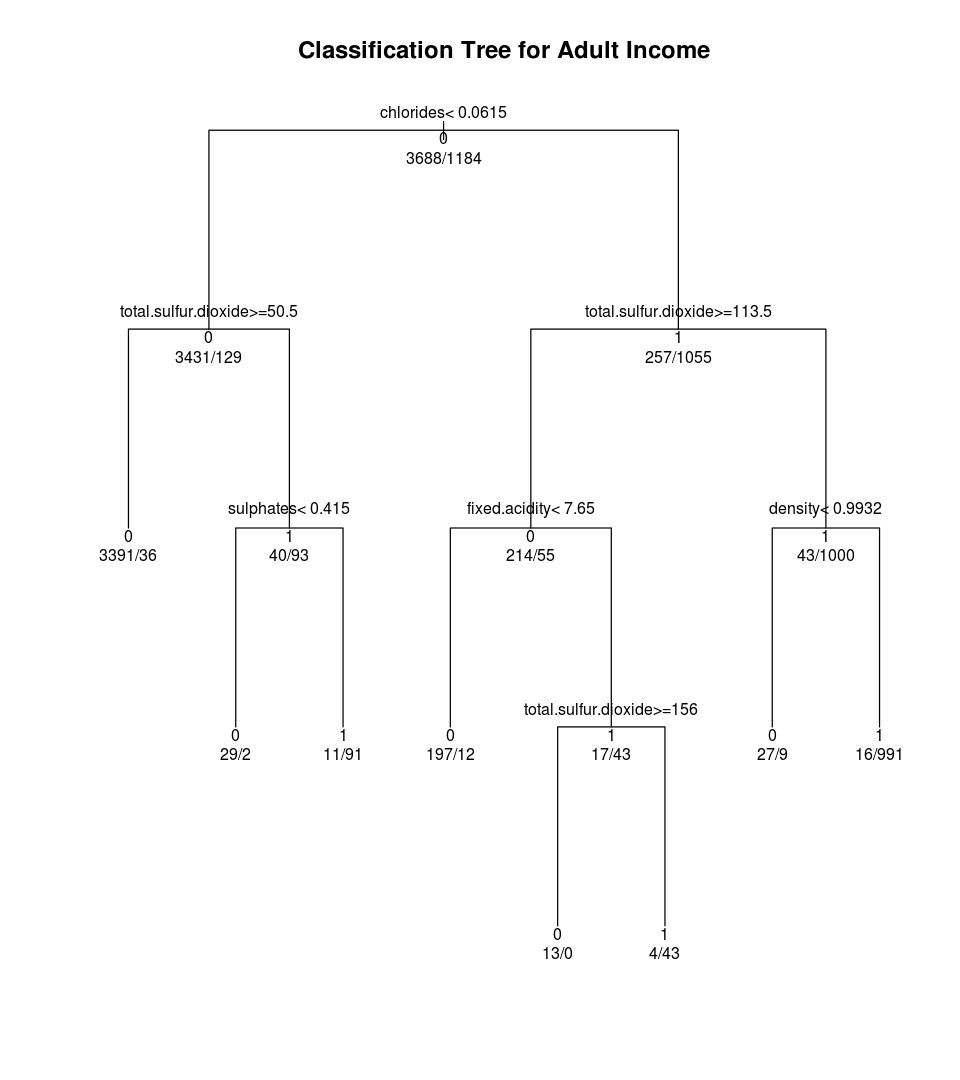

In [47]:
test_tree_accuracy(data, plot=TRUE)

[1] "-------------------------------------------------------------------"
[1] "Class"                "total.sulfur.dioxide" "chlorides"           
[1] "Accuracy=96.86%"
[1] "------------------------------------"
[1] ""


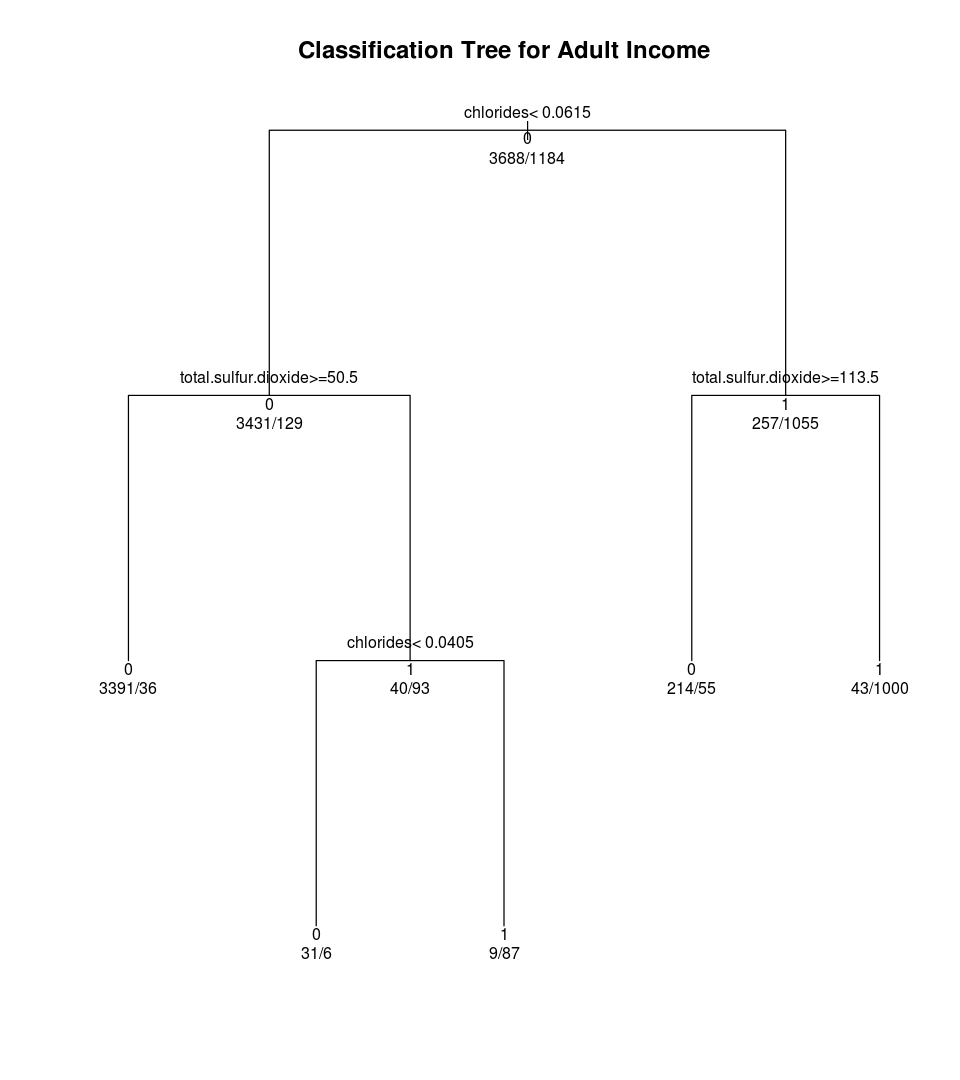

In [54]:
test_tree_accuracy(select(data, one_of(c('Class','total.sulfur.dioxide', 'chlorides'))), plot=TRUE)

In [ ]:
test_tree_accuracy(data, plot=TRUE)

In [ ]:
# Finding the Minimum Number of Attributes
# Comparing to Naive Bayesian Classifier

After googling _R rpart tree pruning_

In [ ]:
fit <- rpart (Class ~ ., method="class", data=data)
printcp (fit)

In [ ]:
options(repr.plot.width=8, repr.plot.height=6)
plotcp(fit)

In [ ]:
summary(fit)

Okay, the sumary says Total Sulfur Dioxide is the most important, follwed by Chloriede. The plot(cp) sugests we can get decent peformance improvment for up to 4 variables, but after that the law of diminishing returns kicks in.

Let's try a tree with total.sulfur.dioxide, chlorides, free.sulfur.dioxide, volatile.acidity

In [ ]:
test_tree_accuracy(select(data, one_of(c('Class','total.sulfur.dioxide', 'chlorides', 
                                         'free.sulfur.dioxide', 'volatile.acidity'))))


Update the leaderboard

|Features| Configuration  | Tree Accuracy | NBC Acuracy |
|--------|----------------|---------------|-------------|
| 12     |All features    | 97.72%        | 97.91%      |
| 1      |sulfur.dioxide  | 93.05%        | 93.11%      |
| 1      |chloride        | 91.94%        | 79.57%      |
| 4      |total.sulfur.dioxide, chlorides, <br> free.sulfure.dioxide, volatile.acidity | 97.29% | n/a |


# Try the ID3 Approach

In [15]:
library(data.tree)

Warning message:
“replacing previous import by ‘tibble::as_tibble’ when loading ‘DiagrammeR’”Warning message:
“replacing previous import by ‘stringr::%>%’ when loading ‘data.tree’”

In [18]:
data_id3 = data
data_id3$Color <- ifelse(datat_id3$Class ==1,'Red','White')
data_id3$Color <- factor(datat_id3$Color)
head(data_id3)

fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality,Class,Color
7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5,1,Red
7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,5,1,Red
7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,5,1,Red
11.2,0.28,0.56,1.9,0.075,17,60,0.9980,3.16,0.58,9.8,6,1,Red
7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5,1,Red
7.4,0.66,0.00,1.8,0.075,13,40,0.9978,3.51,0.56,9.4,5,1,Red


In [19]:
data_id3 = select(datat_id3, -Class)
head(data_id3)

fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality,Color
7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5,Red
7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,5,Red
7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,5,Red
11.2,0.28,0.56,1.9,0.075,17,60,0.9980,3.16,0.58,9.8,6,Red
7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5,Red
7.4,0.66,0.00,1.8,0.075,13,40,0.9978,3.51,0.56,9.4,5,Red


In [23]:
# Compute purity
IsPure <- function(data) {
  length(unique(data[,ncol(data)])) == 1
}

In [24]:
# Compute Entropy - purity of a dataset
Entropy <- function( vls ) {
  res <- vls/sum(vls) * log2(vls/sum(vls))
  res[vls == 0] <- 0
  -sum(res)
}

In [25]:
# Information Gain
#  Measures the difference between the entropy before the split, and the weighted sum of the entropies after the split.
InformationGain <- function( tble ) {
  entropyBefore <- Entropy(colSums(tble))
  s <- rowSums(tble)
  entropyAfter <- sum (s / sum(s) * apply(tble, MARGIN = 1, FUN = Entropy ))
  informationGain <- entropyBefore - entropyAfter
  return (informationGain)
}

In [37]:
#Training
TrainID3 <- function(node, data) {
    
  node$obsCount <- nrow(data)
  
  #if the data-set is pure (e.g. all toxic), then
  if (IsPure(data)) {
    #construct a leaf having the name of the pure feature (e.g. 'toxic')
    child <- node$AddChild(unique(data[,ncol(data)]))
    node$feature <- tail(names(data), 1)
    child$obsCount <- nrow(data)
    child$feature <- ''
  } else {
    #calculate the information gain
    ig <- sapply(colnames(data)[-ncol(data)], 
            function(x) InformationGain(
              table(data[,x], data[,ncol(data)])
              )
            )
    #chose the feature with the highest information gain (e.g. 'color')
    #if more than one feature have the same information gain, then take
    #the first one
    feature <- names(which.max(ig))
    node$feature <- feature
    
    #take the subset of the data-set having that feature value
    
    childObs <- split(data[ ,names(data) != feature, drop = FALSE], 
                      data[ ,feature], 
                      drop = TRUE)
    if (length(childObs) > 0) {
         for(i in 1:length(childObs)) {
          #construct a child having the name of that feature value (e.g. 'red')
          child <- node$AddChild(names(childObs)[i])

          #call the algorithm recursively on the child and the subset      
          TrainID3(child, childObs[[i]])
        }
    }
    
  }
}

In [38]:
tree <- Node$new("data_id3")
tree

  levelName
1  data_id3

In [39]:
TrainID3(tree, data_id3)
tree
# print(tree, "feature", "obsCount")

ERROR: Error in .subset2(x, i, exact = exact): attempt to select less than one element


# ==============< JUNK  V2 >===================================

Reviewing the plots, ranked by least differentiated to most differentiated for ALL params
- total.sulfur.dioxide
- volatile.acidity
- fixed.acidity
- chlorides
- residual.sugar
- free.sulfur.dioxide
- density
- citric.acid
- pH
    
Let's start pruning one feature off at a time and see what happens.

In [ ]:
test_nbc_accuracy(select(data, -one_of(c('pH'))))
test_nbc_accuracy(select(data, -one_of(c('pH','citric.acid'))))
test_nbc_accuracy(select(data, -one_of(c('pH','citric.acid','density'))))
test_nbc_accuracy(select(data, -one_of(c('pH','citric.acid','density','free.sulfur.dioxide'))))
test_nbc_accuracy(select(data, -one_of(c('pH','citric.acid','density','free.sulfur.dioxide',
                                         'residual.sugar'))))
test_nbc_accuracy(select(data, -one_of(c('pH','citric.acid','density','free.sulfur.dioxide',
                                        'residual.sugar','chlorides'))))
test_nbc_accuracy(select(data, -one_of(c('pH','citric.acid','density','free.sulfur.dioxide',
                                        'residual.sugar','chlorides','fixed.acidity'))))
test_nbc_accuracy(select(data, -one_of(c('pH','citric.acid','density','free.sulfur.dioxide',
                                        'residual.sugar','chlorides','fixed.acidity',
                                         'volatile.acidity'))))
test_nbc_accuracy(select(data, -one_of(c('pH','citric.acid','density','free.sulfur.dioxide',
                                         'residual.sugar','chlorides','fixed.acidity',
                                          'volatile.acidity','total.sulfur.dioxide'))))

We got a bump up in accuracy after removing pH and Citric Acid, then it started to degrade. Update the leaderboard.

| Configuration                                      | Acuracy |
|----------------------------------------------------|---------|
|All features                                        | 97.91%  |
|sulfur.dioxide(1)                                   | 93.11%  |
|All but pH ad citric.acid                           | 97.421% |
|total.sulfur.dioxide, sulphates, alcohol, quality(4)| 95.02%  |

Keep density, prune th rest.

In [ ]:
test_nbc_accuracy(select(data, -one_of(c('pH','citric.acid'))))
test_nbc_accuracy(select(data, -one_of(c('pH','citric.acid','free.sulfur.dioxide'))))
test_nbc_accuracy(select(data, -one_of(c('pH','citric.acid','free.sulfur.dioxide',
                                            'residual.sugar'))))
test_nbc_accuracy(select(data, -one_of(c('pH','citric.acid','free.sulfur.dioxide',
                                            'residual.sugar','chlorides'))))
test_nbc_accuracy(select(data, -one_of(c('pH','citric.acid','free.sulfur.dioxide',
                                            'residual.sugar','chlorides','fixed.acidity'))))
test_nbc_accuracy(select(data, -one_of(c('pH','citric.acid','free.sulfur.dioxide',
                                            'residual.sugar','chlorides','fixed.acidity',
                                             'volatile.acidity'))))
test_nbc_accuracy(select(data, -one_of(c('pH','citric.acid','free.sulfur.dioxide',
                                            'residual.sugar','chlorides','fixed.acidity',
                                             'volatile.acidity','total.sulfur.dioxide'))))


We were able to bump it up to 97.91% after pruning some  features. re-start the pruning.  Curent leaderboard.


| Configuration                                      | Acuracy |
|----------------------------------------------------|---------|
|All features                                        | 97.91%  |
|sulfur.dioxide(1)                                   | 93.11%  |
|All but pH ad citric.acid                           | 97.41%  |
|total.sulfur.dioxide, sulphates, alcohol, quality(4)| 95.02%  |
| 7 features                                         | 97.91%  |


In [ ]:
pruned_data <- select(data, c("fixed.acidity", "volatile.acidity", "total.sulfur.dioxide",
                              "density", "sulphates", "alcohol",
                              "quality", "Class" ))

Remembering our ranking
 - total.sulfur.dioxide
 - volatile.acidity
 - fixed.acidity
 - chlorides
 - residual.sugar
 - free.sulfur.dioxide
 - density
 - citric.acid
 - pH


In [ ]:
test_nbc_accuracy(select(pruned_data, -one_of(c('quality'))))
test_nbc_accuracy(select(pruned_data, -one_of(c('quality','density'))))
test_nbc_accuracy(select(pruned_data, -one_of(c('quality','density','fixed.acidity','volatile.acidity'))))

Got it down to three fatures, while keeping 94.89% accuracy. Updating the leaderboard.
    
| Configuration                                      | Acuracy |
|----------------------------------------------------|---------|
|All features                                        | 97.91%  |
|sulfur.dioxide(1)                                   | 93.11%  |
|All but pH ad citric.acid                           | 97.41%  |
|total.sulfur.dioxide, sulphates, alcohol, quality(4)| 95.02%  |
| 7 features                                         | 97.91%  | 
|total.sulfur.dioxide, sulphates, alcohol            | 94.89%  |

Let's try to prune it down to two.

In [ ]:
pruned_data2 <- select(data, c("total.sulfur.dioxide", "sulphates", "alcohol", "Class" ))

test_nbc_accuracy(select(pruned_data2, -one_of(c('total.sulfur.dioxide'))))
test_nbc_accuracy(select(pruned_data2, -one_of(c('sulphates'))))
test_nbc_accuracy(select(pruned_data2, -one_of(c('alcohol'))))

One last update of the leaderboard

|Features| Configuration                                      | Acuracy |
|--------|----------------------------------------------------|---------|
| 12     |All features                                        | 97.91%  |
| 1      |sulfur.dioxide                                      | 93.11%  |
| 10     |All but pH and citric.acid                          | 97.41%  |
| 4      |total.sulfur.dioxide, sulphates, alcohol, quality   | 95.02%  |
| 7      |features                                            | 97.91%  | 
| 3      |total.sulfur.dioxide, sulphates, alcohol            | 94.89%  |
| 2      |total.sulfur.dioxide, sulphates                     | 94.71%  |


# CONCLUSIONS
## Using all features gets you 97.91% accuracy
## You can drop to one feature (Sulfur Dioxide) and still get 93.11%
## With two features (choose carefully) you can get 94.71%